Waymo Open Dataset modules imported successfully.
Output directory '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/' ensured.

--- Starting Plot Generation ---
Checking input directory: /home/hamdarlab/Desktop/Waymo/data20s/
Plots will be saved to: /home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/
Output directory '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/' ensured.

Found 20 TFRecord files to process.
  Found file 1: /home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00000-of-01000
  Found file 2: /home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00001-of-01000
  Found file 3: /home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00002-of-01000
  Found file 4: /home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00003-of-01000
  Found file 5: /home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00004-of-01000
  ...

[1/20] Processing 'training_20s.tfrecord-00000-of-01000' from '/home/hamdarlab/Desktop

2025-05-24 14:54:05.364031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


  Attempting to parse scenario 0...
  Successfully parsed scenario 0 (ID: 41600af30ab8cc55).
  - Saved plot for scenario 41600af30ab8cc55 to '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/training_20s_scenario_41600af30ab8cc55.png'
  Attempting to parse scenario 1...
  Successfully parsed scenario 1 (ID: 2aa43fad083efbf3).
  - Saved plot for scenario 2aa43fad083efbf3 to '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/training_20s_scenario_2aa43fad083efbf3.png'
  Attempting to parse scenario 2...
  Successfully parsed scenario 2 (ID: eb073968f66914c7).
  - Saved plot for scenario eb073968f66914c7 to '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/training_20s_scenario_eb073968f66914c7.png'
  Attempting to parse scenario 3...
  Successfully parsed scenario 3 (ID: cebdf28156152fd6).
  - Saved plot for scenario cebdf28156152fd6 to '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/training_20s_scenario_cebdf28156152fd6.png'
  Attempting

KeyboardInterrupt: 

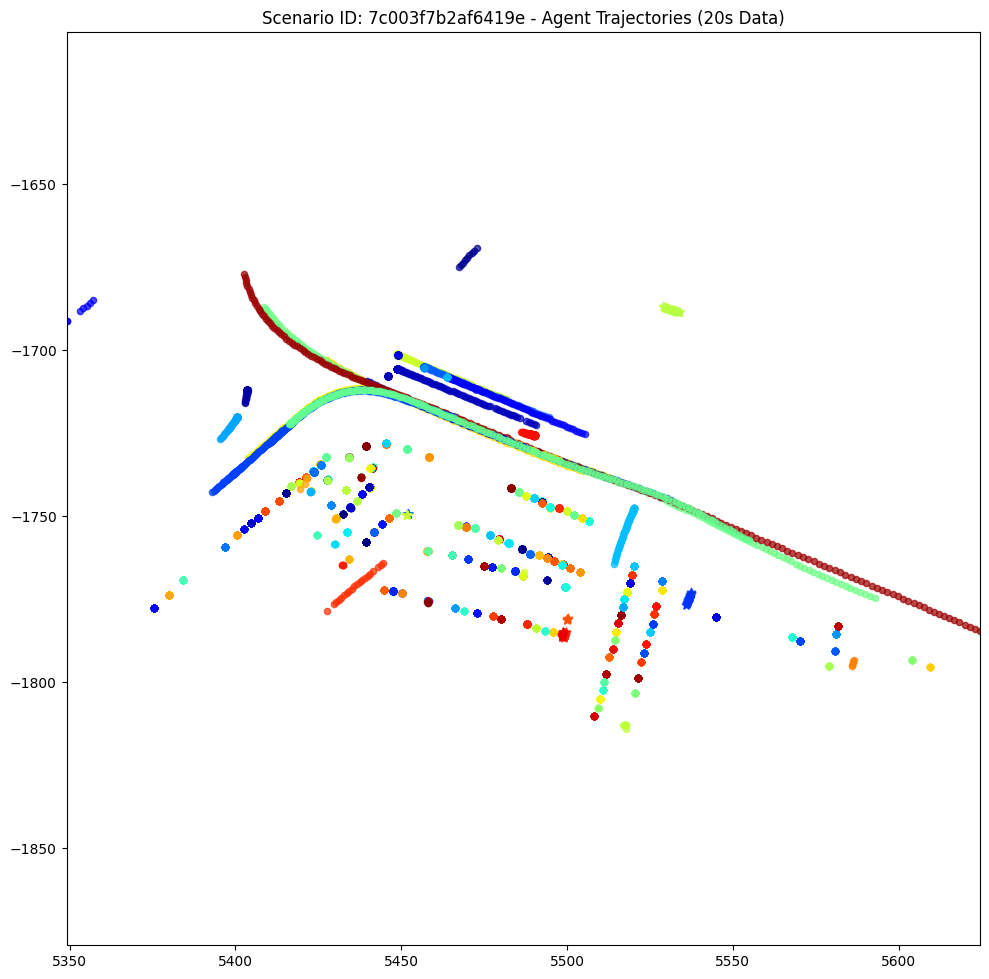

In [2]:
import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf

# Assuming Waymo Open Dataset protos and utilities are correctly installed
try:
    from google.protobuf import text_format
    from waymo_open_dataset.protos import scenario_pb2
    from waymo_open_dataset.metrics.ops import py_metrics_ops
    from waymo_open_dataset.metrics.python import config_util_py as config_util
    from waymo_open_dataset.protos import motion_metrics_pb2
    print("Waymo Open Dataset modules imported successfully.")
except ImportError as e:
    print(f"Error importing Waymo modules: {e}")
    print("Please ensure 'waymo-open-dataset' is installed: pip install waymo-open-dataset")
    exit()

# Define input and output directories
INPUT_DIR = '/home/hamdarlab/Desktop/Waymo/data20s/' # Adjust if your path changed
OUTPUT_DIR = '/home/hamdarlab/Desktop/Waymo/data20s/plots_scenarios_wo_map/' # Changed output folder for clarity

# Create the output directory if it doesn't exist
try:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output directory '{OUTPUT_DIR}' ensured.")
except OSError as e:
    print(f"Error creating output directory '{OUTPUT_DIR}': {e}")
    print("Please check directory permissions.")
    exit()

# Helper functions for plotting setup
def create_figure_and_axes(size_pixels):
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax


def fig_canvas_image(fig):
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def get_colormap(num_agents):
  colors = cm.get_cmap('jet', num_agents)
  colors = colors(range(num_agents))
  np.random.shuffle(colors)
  return colors


def get_viewport(all_states, all_states_mask):
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  if valid_states.size == 0:
      return 0, 0, 10 # Default to a small viewport if no valid states

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y) # Peak-to-peak range
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width


# --- MODIFIED visualize_scenario_static function (Added robustness for empty agent data) ---
def visualize_scenario_static(
    scenario_proto,
    size_pixels=1000,
):
  """Visualizes all agent trajectories in a single static image from a Scenario proto,
  without the roadgraph background.

  This version dynamically determines the number of timesteps and sets a 'current'
  point for visualization, making it suitable for datasets with varying lengths
  like the 20-second Waymo Open Dataset scenarios (which often have 198-200 timesteps).
  It uses consistent scatter shapes/sizes for past/current/future, and different
  shapes for vehicles vs. other object types.

  Args:
    scenario_proto: A waymo_open_dataset.protos.scenario_pb2.Scenario object.
    size_pixels: The size in pixels of the output image.

  Returns:
    A [H, W, 3] uint8 np.array of the drawn matplotlib's figure canvas, or None if no data to plot.
  """
  if not scenario_proto.tracks:
      return None

  # Find the first track with states to determine the total_steps
  total_steps = 0
  for track in scenario_proto.tracks:
      if track.states:
          total_steps = len(track.states)
          break
  
  if total_steps == 0:
      return None

  # Define the split for past, current, and future for visualization purposes.
  vis_current_time_idx = min(99, total_steps - 1) 

  num_past_vis_steps = vis_current_time_idx
  num_current_vis_steps = 1
  num_future_vis_steps = total_steps - (num_past_vis_steps + num_current_vis_steps)

  if num_future_vis_steps < 0:
      num_future_vis_steps = 0


  # Extract agent data and object types from scenario_proto.tracks
  initial_num_agents = len(scenario_proto.tracks)

  # Initialize arrays to store agent data and object types
  all_agent_states = np.zeros((initial_num_agents, total_steps, 2), dtype=np.float32)
  all_agent_masks = np.zeros((initial_num_agents, total_steps), dtype=bool)
  agent_object_types = np.zeros(initial_num_agents, dtype=int) 

  valid_agent_indices = []
  for agent_idx, track in enumerate(scenario_proto.tracks):
      if len(track.states) != total_steps:
          print(f"  WARNING: Scenario {scenario_proto.scenario_id}, Track {track.id} has {len(track.states)} states, expected {total_steps}. Skipping this track for plotting.")
          continue
      
      valid_agent_indices.append(agent_idx)
      agent_object_types[agent_idx] = track.object_type 
      
      for array_idx, state in enumerate(track.states):
          all_agent_states[agent_idx, array_idx, 0] = state.center_x
          all_agent_states[agent_idx, array_idx, 1] = state.center_y
          all_agent_masks[agent_idx, array_idx] = state.valid
  
  # Filter to include only valid agents based on valid_agent_indices
  # This step creates new arrays containing only the data for valid agents
  all_agent_states = all_agent_states[valid_agent_indices, :, :]
  all_agent_masks = all_agent_masks[valid_agent_indices, :]
  agent_object_types = agent_object_types[valid_agent_indices]
  num_agents = all_agent_states.shape[0] # Recalculate num_agents after filtering

  # === ADDED ROBUSTNESS CHECK ===
  # If after filtering, there are no agents left, return None.
  # This prevents 'name not defined' errors if no valid agents remain.
  if num_agents == 0:
      print(f"  Note: Scenario {scenario_proto.scenario_id}: No valid agents to plot after all filtering steps. Returning None.")
      return None
  # ==============================

  # Now, past_states, current_states, future_states will always be defined
  # as NumPy arrays (even if they are empty for some time steps due to masking, not due to num_agents=0).
  past_states = all_agent_states[:, :vis_current_time_idx, :]
  past_states_mask = all_agent_masks[:, :vis_current_time_idx]

  current_states = all_agent_states[:, vis_current_time_idx : vis_current_time_idx + num_current_vis_steps, :]
  current_states_mask = all_agent_masks[:, vis_current_time_idx : vis_current_time_idx + num_current_vis_steps]

  future_states = all_agent_states[:, vis_current_time_idx + num_current_vis_steps :, :]
  future_states_mask = all_agent_masks[:, vis_current_time_idx + num_current_vis_steps :]


  # Roadgraph data extraction (kept for viewport calculation, but not plotted)
  roadgraph_xyz = []
  for map_feature in scenario_proto.map_features:
      if map_feature.HasField('lane'):
          for point in map_feature.lane.polyline:
              roadgraph_xyz.append([point.x, point.y, point.z])
      elif map_feature.HasField('road_line'):
          for point in map_feature.road_line.polyline:
              roadgraph_xyz.append([point.x, point.y, point.z])
      elif map_feature.HasField('road_edge'):
          for point in map_feature.road_edge.polyline:
              roadgraph_xyz.append([point.x, point.y, point.z])
      elif map_feature.HasField('stop_sign'):
          roadgraph_xyz.append([map_feature.stop_sign.position.x, map_feature.stop_sign.position.y, map_feature.stop_sign.position.z])
      elif map_feature.HasField('crosswalk'):
          for point in map_feature.crosswalk.polygon:
              roadgraph_xyz.append([point.x, point.y, point.z])

  roadgraph_xyz = np.array(roadgraph_xyz, dtype=np.float32) if roadgraph_xyz else None

  color_map = get_colormap(num_agents)

  # Combine all states for viewport calculation
  all_states_for_viewport = np.concatenate([past_states, current_states, future_states], axis=1)
  all_states_mask_for_viewport = np.concatenate(
      [past_states_mask, current_states_mask, future_states_mask], axis=1)

  center_y, center_x, width = get_viewport(all_states_for_viewport, all_states_mask_for_viewport)

  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # --- COMMENTED OUT: Plot roadgraph ---
  # if roadgraph_xyz is not None and roadgraph_xyz.size > 0:
  #     rg_pts = roadgraph_xyz[:, :2].T
  #     ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)
  # else:
  #     print(f"  Note: Scenario {scenario_proto.scenario_id}: No valid roadgraph data found in this scenario. Skipping roadgraph plot.")


  # --- Plotting agents with consistent shape/size and type-based markers ---
  # Define consistent plotting parameters
  vehicle_marker = 'o'
  other_marker = '*'
  marker_size = 20 # Consistent size for all points
  star_marker_size = 40 # Slightly larger for stars to be visible
  line_width = 1
  alpha_value = 0.7 # Consistent transparency for all points

  for agent_idx in range(num_agents):
      agent_color = color_map[agent_idx]
      
      # Determine marker based on object type
      current_marker = vehicle_marker
      current_marker_size = marker_size
      if agent_object_types[agent_idx] != scenario_pb2.Track.ObjectType.TYPE_VEHICLE:
          current_marker = other_marker
          current_marker_size = star_marker_size

      # Plot past positions for this agent
      past_x = past_states[agent_idx, :, 0][past_states_mask[agent_idx, :]]
      past_y = past_states[agent_idx, :, 1][past_states_mask[agent_idx, :]]
      ax.scatter(
          past_x,
          past_y,
          marker=current_marker,
          linewidths=line_width,
          color=agent_color,
          alpha=alpha_value,
          s=current_marker_size
      )

      # Plot current position for this agent
      current_x = current_states[agent_idx, 0, 0][current_states_mask[agent_idx, 0]]
      current_y = current_states[agent_idx, 0, 1][current_states_mask[agent_idx, 0]]
      if current_states_mask[agent_idx, 0]: # Only plot if valid
          ax.scatter(
              current_x,
              current_y,
              marker=current_marker,
              linewidths=line_width,
              color=agent_color,
              alpha=alpha_value,
              s=current_marker_size * 1.5 # Make current slightly larger for emphasis
          )

      # Plot future positions for this agent
      future_x = future_states[agent_idx, :, 0][future_states_mask[agent_idx, :]]
      future_y = future_states[agent_idx, :, 1][future_states_mask[agent_idx, :]]
      ax.scatter(
          future_x,
          future_y,
          marker=current_marker,
          linewidths=line_width,
          color=agent_color,
          alpha=alpha_value,
          s=current_marker_size
      )

  ax.set_title(f'Scenario ID: {scenario_proto.scenario_id} - Agent Trajectories (20s Data)')

  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  plt.close(fig)
  return image


# --- Main script to process all files ---
print(f"\n--- Starting Plot Generation ---")
print(f"Checking input directory: {INPUT_DIR}")
print(f"Plots will be saved to: {OUTPUT_DIR}")

try:
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Output directory '{OUTPUT_DIR}' ensured.")
except OSError as e:
    print(f"Error creating output directory '{OUTPUT_DIR}': {e}")
    print("Please check directory permissions.")
    exit()

tfrecord_files = []
for root, _, files in os.walk(INPUT_DIR):
    for f in files:
        if '.tfrecord' in f:
            tfrecord_files.append(os.path.join(root, f))

tfrecord_files.sort()

if not tfrecord_files:
    print(f"\nERROR: No TFRecord files found in '{INPUT_DIR}'.")
    print("Please double-check the 'INPUT_DIR' path and the file naming convention (e.g., '.tfrecord').")
    print("Example: '/home/hamdarlab/Desktop/Waymo/data20s/training_20s.tfrecord-00000-of-01000'")
else:
    print(f"\nFound {len(tfrecord_files)} TFRecord files to process.")
    for k, found_file in enumerate(tfrecord_files[:5]):
        print(f"  Found file {k+1}: {found_file}")
    if len(tfrecord_files) > 5:
        print("  ...")

    for i, full_filepath in enumerate(tfrecord_files):
        filename = os.path.basename(full_filepath)
        base_output_name = os.path.splitext(filename)[0]
        output_filepath_prefix = os.path.join(OUTPUT_DIR, base_output_name)

        print(f"\n[{i+1}/{len(tfrecord_files)}] Processing '{filename}' from '{full_filepath}'...")
        try:
            dataset = tf.data.TFRecordDataset(full_filepath, compression_type='')
            
            successful_plots_in_file = 0

            for j, data_bytes in enumerate(dataset.as_numpy_iterator()):
                try:
                    print(f"  Attempting to parse scenario {j}...")
                    scenario = scenario_pb2.Scenario()
                    scenario.ParseFromString(data_bytes)
                    print(f"  Successfully parsed scenario {j} (ID: {scenario.scenario_id}).")
                    
                    plot_image = visualize_scenario_static(scenario)
                    
                    if plot_image is None or plot_image.size == 0:
                        print(f"  - No plot generated for scenario {scenario.scenario_id} (likely due to no valid agents).")
                        continue

                    scenario_output_filepath = f"{output_filepath_prefix}_scenario_{scenario.scenario_id}.png"
                    plt.imsave(scenario_output_filepath, plot_image)
                    print(f"  - Saved plot for scenario {scenario.scenario_id} to '{scenario_output_filepath}'")
                    successful_plots_in_file += 1

                except Exception as e:
                    print(f"  - WARNING: An error occurred while processing scenario {j} (ID: {scenario.scenario_id if 'scenario' in locals() else 'N/A'}) in '{filename}': {e}")
                    continue
            
            if successful_plots_in_file == 0:
                print(f"  - All scenarios in '{filename}' were processed, but none were successfully plotted.")
            else:
                print(f"  - Successfully plotted {successful_plots_in_file} scenarios from '{filename}'.")

        except tf.errors.DataLossError as e:
            print(f"  - ERROR: Data loss or corruption detected in '{filename}': {e}")
            print("  - Skipping this file.")
        except Exception as e:
            print(f"  - ERROR: General error loading or processing file '{filename}': {e}")
            print("  - Skipping this file.")

print("\n--- Plotting process complete. ---")
print(f"Check '{OUTPUT_DIR}' for generated images.")